In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from scipy import misc
import numpy as np
import glob
import matplotlib.pyplot as plt
from network import Network
from circle_generator import Circles
from dataset import SegmentationDataset
from loss import SegmentationLoss, ImageLoss

### Train on HeLa dataset

In [2]:
def train(num_epochs, batch_size, num_workers):
    transformed_dataset = SegmentationDataset(path_to_images='./datasets/HeLa/01/',
                                              path_to_segm='./datasets/HeLa/01_GT/SEG/', 
                                              transform=transforms.Compose([
                                                  ToTensor(), 
                                                  Normalize()
                                              ]))
    dataloader = DataLoader(transformed_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    
    net = network()
    segm_loss = SegmentationLoss()
    img_loss = ImageLoss()
    z_input = Variable(torch.randn(84, 1, 512, 512), requires_grad=True)
    optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.1)
    
    for epoch in range(num_epochs):
        
        for data in dataloader:
            gt_img = Variable(data['image'])
            idx = data['idx']
            
            optimizer.zero_grad()
            img, segm = net(z_input[idx])
            loss = img_loss(img, gt_img)
            loss.backward()
            optimizer.step()
        

In [ ]:
train(1, 2, 1)

### circles example

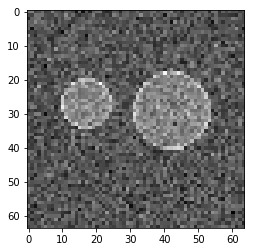

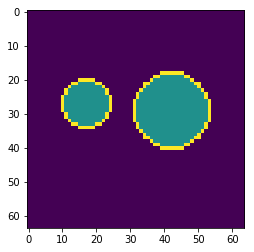

In [3]:
predata = Circles(radius=12, bg_color=0, perim_color=0.2, circle_color=0.1,
                  size=(64, 64), n_obj=5, var_n_obj=1, var_size=5, maxover=0)
x, y = predata.get_train_batch(1)
plt.imshow(x[0, 0],cmap='gray')
plt.figure()
plt.imshow(y[0])
plt.show()

## Training circles

In [4]:
def show_image_segm(gen_img, gen_segm, real_img, real_segm):
    for i, image in enumerate(gen_img):
        f, axarr = plt.subplots(2, 2, figsize=(10, 10))
        axarr[0, 0].imshow(image[0], cmap='gray')
        axarr[0, 0].set_title('Gen image')
        axarr[0, 1].imshow(real_img[i][0], cmap='gray')
        axarr[0, 1].set_title('Real image')
        axarr[1, 0].imshow(np.argmax(gen_segm[i], 0))
        axarr[1, 0].set_title('Gen segmentation')
        axarr[1, 1].imshow(real_segm[i])
        axarr[1, 1].set_title('Real segmentation')
    plt.show()

### Generate train batch

In [5]:
batch_size = 40

In [6]:
np.random.seed(42)
train_images, train_segmentation = predata.get_train_batch(batch_size)

In [7]:
train_images = Variable(torch.from_numpy(train_images).float(), requires_grad=False)
train_segmentation = Variable(torch.from_numpy(train_segmentation), requires_grad=False)

In [8]:
net = Network(num_z_channels=3, num_classes=3)
segm_loss = SegmentationLoss()
img_loss = ImageLoss()

### create latent variable

In [9]:
torch.manual_seed(42)
z_input = Variable(torch.randn(batch_size, 3, 64, 64), requires_grad=True)

### Training

In [10]:
def normalize_z(z):
    norm_z = z.data.norm(dim=1, p=2)
    norm_z = norm_z.unsqueeze(dim=1)
    norm_z = norm_z.repeat(1, 3, 1, 1)
    norm_z.clamp_(min=1.0)
    z.data = z.data / norm_z

In [11]:
optimizer = optim.Adam([z_input] + list(net.parameters()), lr=0.001)

loss_epoch = []
num_epochs = 1000

for epoch in range(num_epochs):
    normalize_z(z_input)
    optimizer.zero_grad()   
    img, segm = net(z_input)
    loss = segm_loss(segm, train_segmentation) + 1000 * img_loss(img, train_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_input)

epoch - 0, loss - 8.312366485595703
epoch - 1, loss - 45.905635833740234
epoch - 2, loss - 6.706514358520508
epoch - 3, loss - 6.8608856201171875
epoch - 4, loss - 7.820627212524414
epoch - 5, loss - 8.181916236877441
epoch - 6, loss - 8.195819854736328
epoch - 7, loss - 7.974825859069824
epoch - 8, loss - 7.570438385009766
epoch - 9, loss - 7.0691094398498535
epoch - 10, loss - 6.556711673736572
epoch - 11, loss - 6.102166652679443
epoch - 12, loss - 6.259113788604736
epoch - 13, loss - 6.556151866912842
epoch - 14, loss - 6.241334438323975
epoch - 15, loss - 6.010616779327393
epoch - 16, loss - 6.021905899047852
epoch - 17, loss - 6.119593143463135
epoch - 18, loss - 6.183096408843994
epoch - 19, loss - 6.172911167144775
epoch - 20, loss - 6.098877906799316
epoch - 21, loss - 5.997947692871094
epoch - 22, loss - 5.920565128326416
epoch - 23, loss - 5.908220291137695
epoch - 24, loss - 5.9529128074646
epoch - 25, loss - 5.984097480773926
epoch - 26, loss - 5.947815418243408
epoch - 27

epoch - 218, loss - 3.0377535820007324
epoch - 219, loss - 3.01765513420105
epoch - 220, loss - 3.019630193710327
epoch - 221, loss - 3.022099018096924
epoch - 222, loss - 3.0125699043273926
epoch - 223, loss - 3.0029661655426025
epoch - 224, loss - 3.0106303691864014
epoch - 225, loss - 3.012929677963257
epoch - 226, loss - 3.0304512977600098
epoch - 227, loss - 3.067243814468384
epoch - 228, loss - 3.0973732471466064
epoch - 229, loss - 3.103562116622925
epoch - 230, loss - 3.015746831893921
epoch - 231, loss - 2.9755945205688477
epoch - 232, loss - 3.0056707859039307
epoch - 233, loss - 3.024272918701172
epoch - 234, loss - 2.9886906147003174
epoch - 235, loss - 2.9637563228607178
epoch - 236, loss - 2.977649450302124
epoch - 237, loss - 2.9881300926208496
epoch - 238, loss - 2.9582433700561523
epoch - 239, loss - 2.9540843963623047
epoch - 240, loss - 2.9639856815338135
epoch - 241, loss - 2.9550046920776367
epoch - 242, loss - 2.9370861053466797
epoch - 243, loss - 2.9359538555145

epoch - 431, loss - 2.182307243347168
epoch - 432, loss - 2.1456007957458496
epoch - 433, loss - 2.155001401901245
epoch - 434, loss - 2.146801233291626
epoch - 435, loss - 2.1371922492980957
epoch - 436, loss - 2.116318702697754
epoch - 437, loss - 2.1278672218322754
epoch - 438, loss - 2.1165881156921387
epoch - 439, loss - 2.107154130935669
epoch - 440, loss - 2.1084651947021484
epoch - 441, loss - 2.1086251735687256
epoch - 442, loss - 2.094244956970215
epoch - 443, loss - 2.0874133110046387
epoch - 444, loss - 2.0887343883514404
epoch - 445, loss - 2.0774803161621094
epoch - 446, loss - 2.0658833980560303
epoch - 447, loss - 2.065011501312256
epoch - 448, loss - 2.0666587352752686
epoch - 449, loss - 2.067233085632324
epoch - 450, loss - 2.075634717941284
epoch - 451, loss - 2.0964972972869873
epoch - 452, loss - 2.1319968700408936
epoch - 453, loss - 2.1265437602996826
epoch - 454, loss - 2.134394884109497
epoch - 455, loss - 2.119504451751709
epoch - 456, loss - 2.07814741134643

epoch - 643, loss - 1.196123480796814
epoch - 644, loss - 1.203787088394165
epoch - 645, loss - 1.192802906036377
epoch - 646, loss - 1.1549214124679565
epoch - 647, loss - 1.1308146715164185
epoch - 648, loss - 1.1214678287506104
epoch - 649, loss - 1.129972219467163
epoch - 650, loss - 1.1467922925949097
epoch - 651, loss - 1.1549692153930664
epoch - 652, loss - 1.1651604175567627
epoch - 653, loss - 1.1667213439941406
epoch - 654, loss - 1.167382001876831
epoch - 655, loss - 1.1326512098312378
epoch - 656, loss - 1.1109998226165771
epoch - 657, loss - 1.0878363847732544
epoch - 658, loss - 1.080603837966919
epoch - 659, loss - 1.086879014968872
epoch - 660, loss - 1.0838558673858643
epoch - 661, loss - 1.0780922174453735
epoch - 662, loss - 1.0737149715423584
epoch - 663, loss - 1.0694328546524048
epoch - 664, loss - 1.0632820129394531
epoch - 665, loss - 1.0613970756530762
epoch - 666, loss - 1.0522934198379517
epoch - 667, loss - 1.0413316488265991
epoch - 668, loss - 1.0374985933

epoch - 854, loss - 0.508471667766571
epoch - 855, loss - 0.5062089562416077
epoch - 856, loss - 0.5115416646003723
epoch - 857, loss - 0.5218454599380493
epoch - 858, loss - 0.5565988421440125
epoch - 859, loss - 0.59791499376297
epoch - 860, loss - 0.6803452968597412
epoch - 861, loss - 0.7059552073478699
epoch - 862, loss - 0.7130839228630066
epoch - 863, loss - 0.6403956413269043
epoch - 864, loss - 0.5743703246116638
epoch - 865, loss - 0.5314304828643799
epoch - 866, loss - 0.5348235368728638
epoch - 867, loss - 0.5617889165878296
epoch - 868, loss - 0.5753646492958069
epoch - 869, loss - 0.5688794255256653
epoch - 870, loss - 0.5223599076271057
epoch - 871, loss - 0.4899415075778961
epoch - 872, loss - 0.5085261464118958
epoch - 873, loss - 0.5189206004142761
epoch - 874, loss - 0.5294197201728821
epoch - 875, loss - 0.509181797504425
epoch - 876, loss - 0.4828469455242157
epoch - 877, loss - 0.4691198170185089
epoch - 878, loss - 0.47987064719200134
epoch - 879, loss - 0.500177

In [62]:
torch.save(net.state_dict(), './model-1000')

### learning

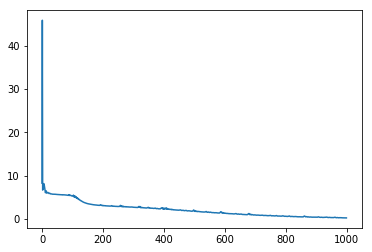

In [12]:
plt.plot(loss_epoch)
plt.show()

In [13]:
img, segm = net(z_input)

### Results 

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


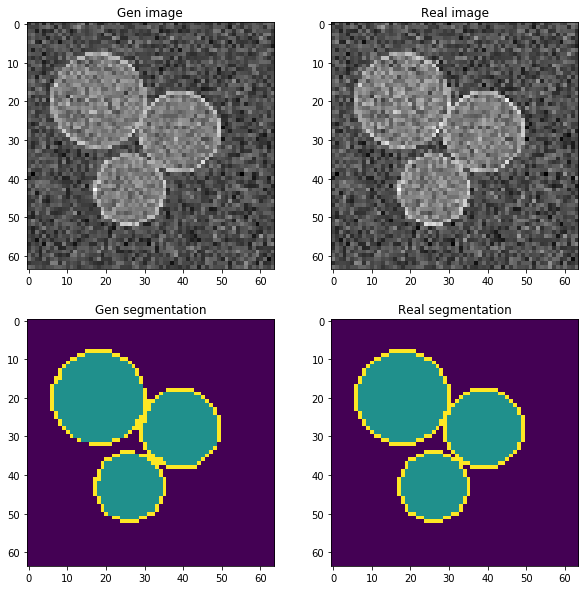

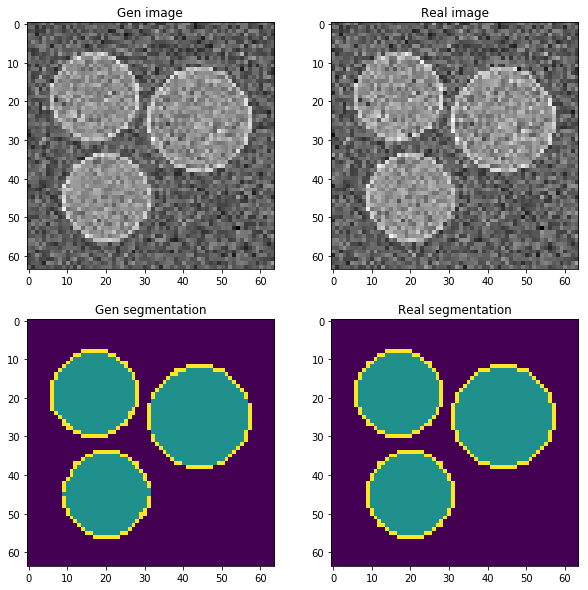

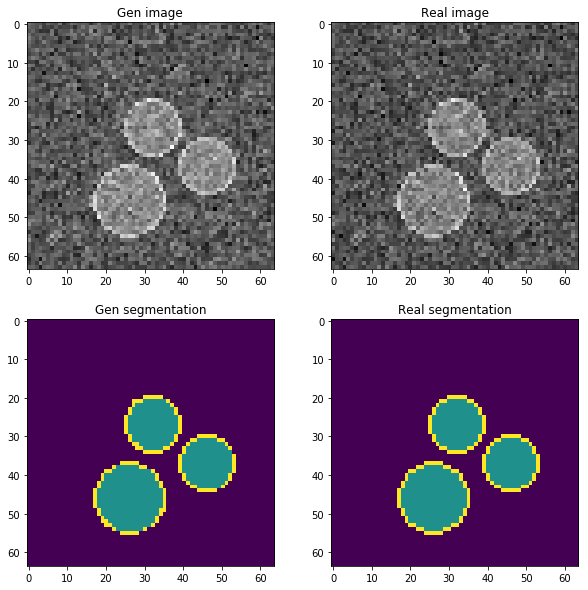

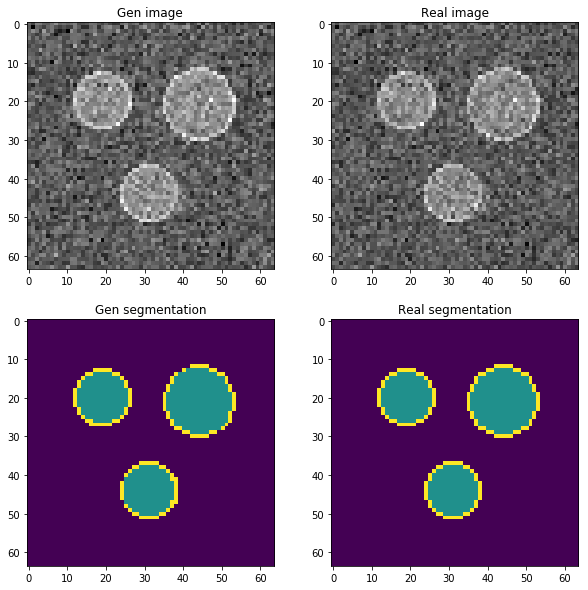

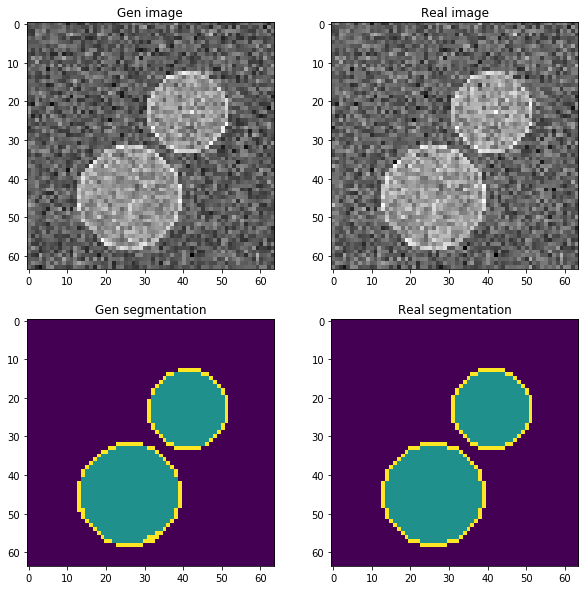

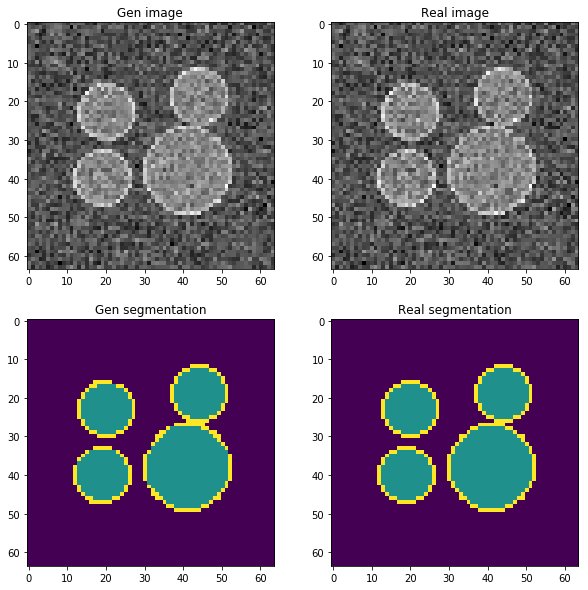

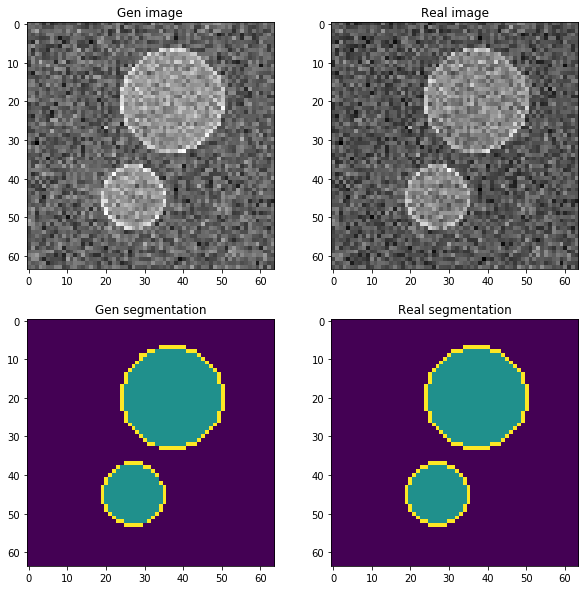

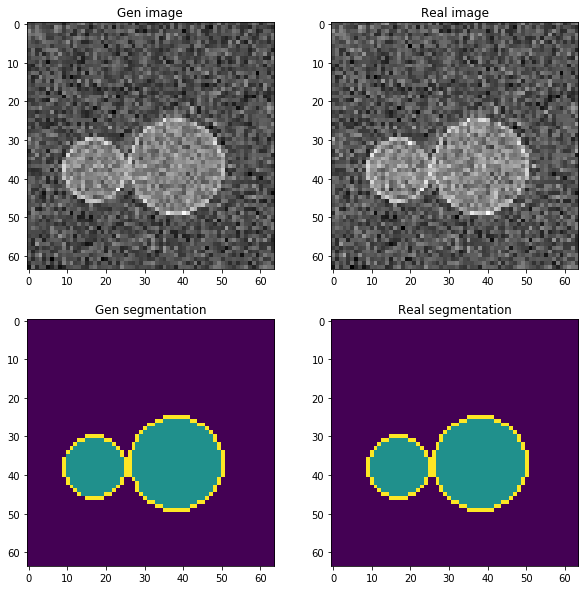

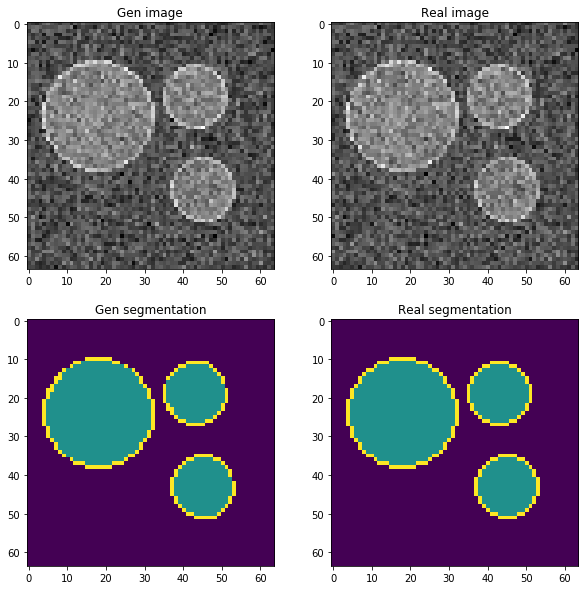

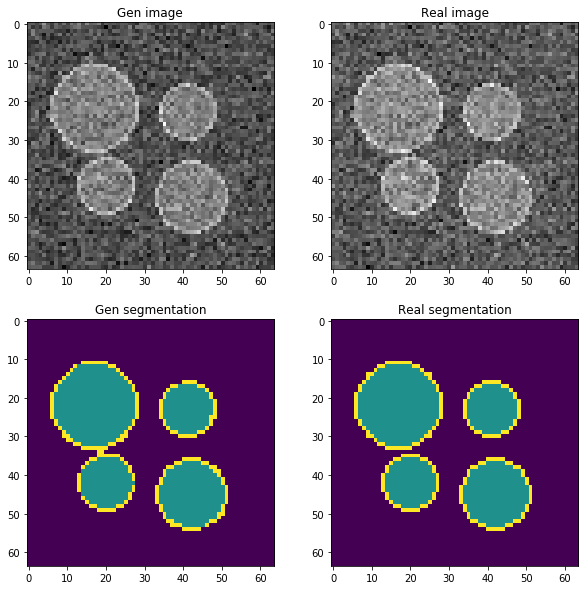

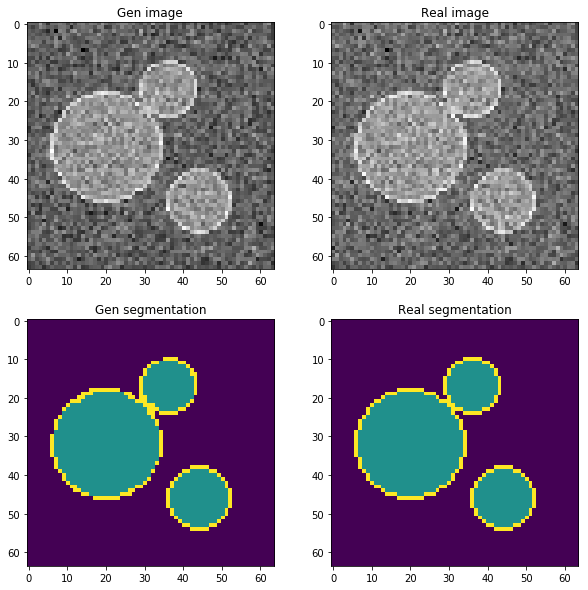

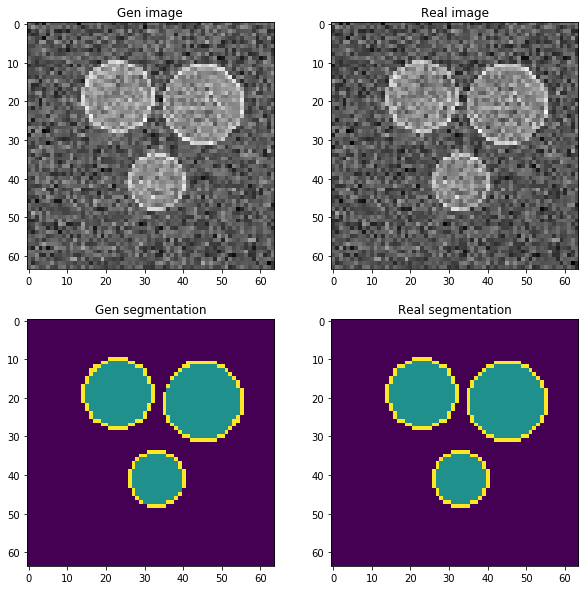

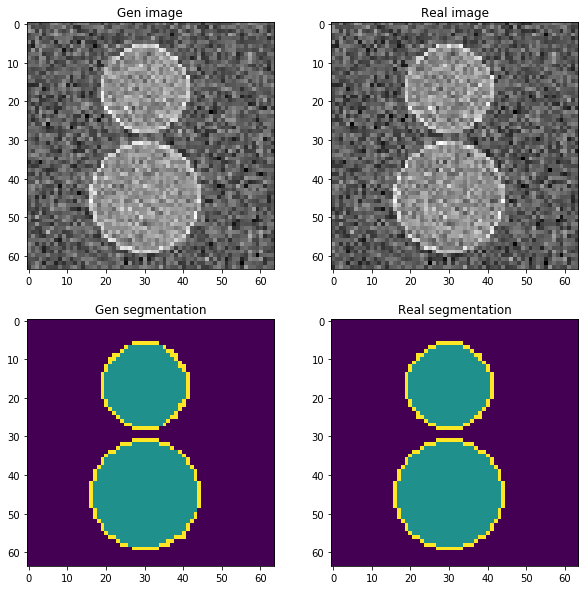

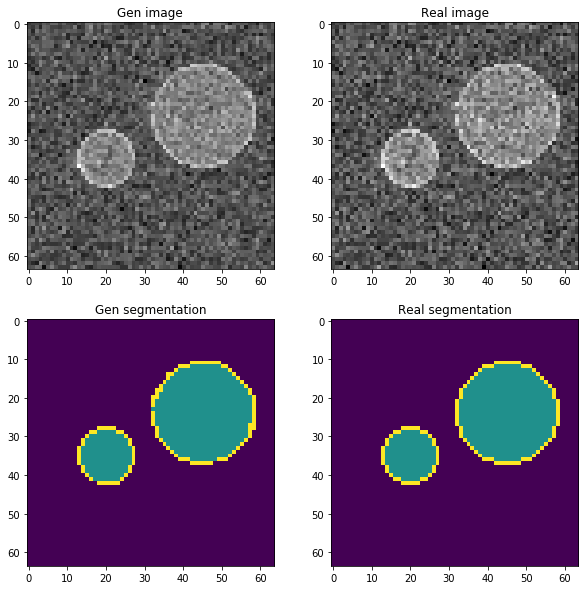

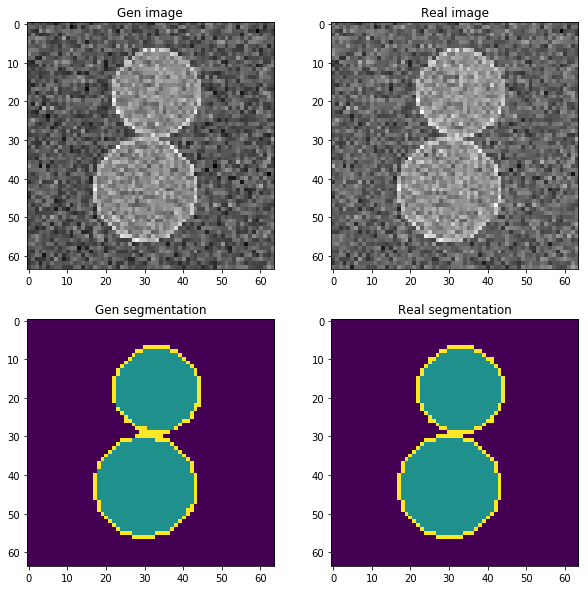

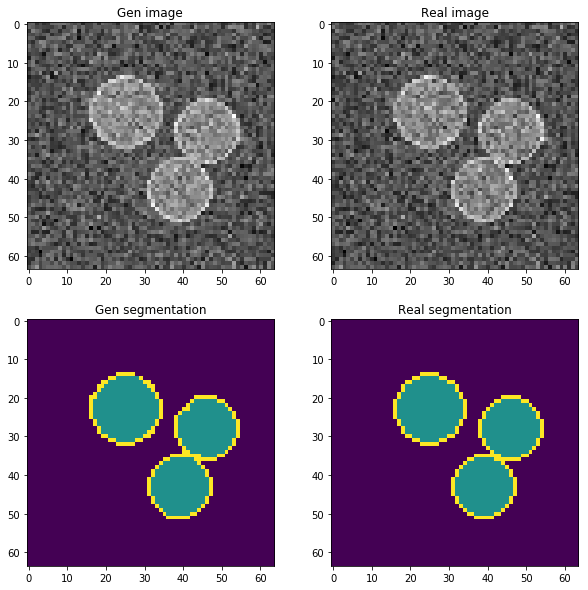

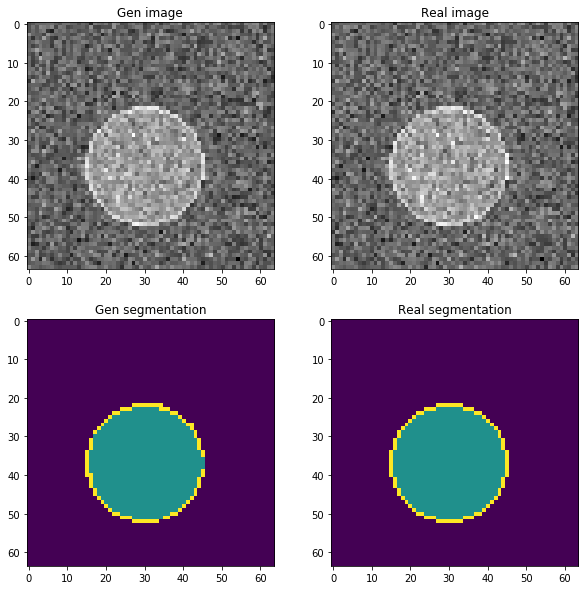

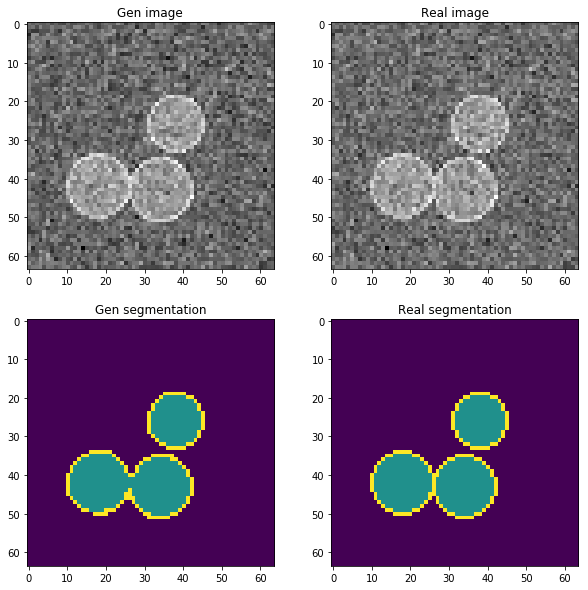

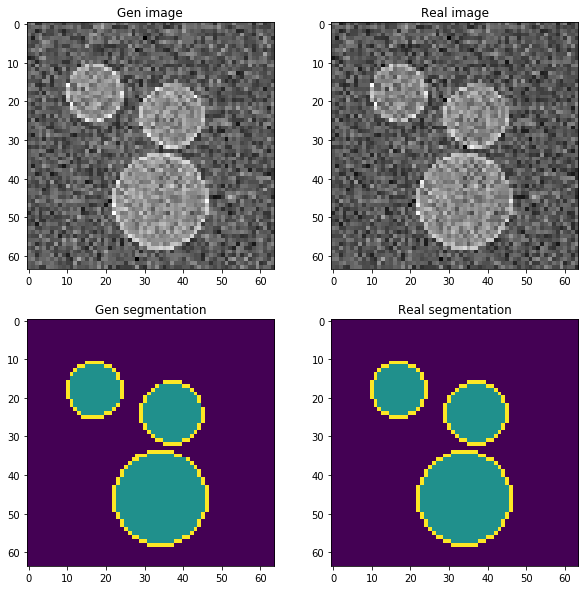

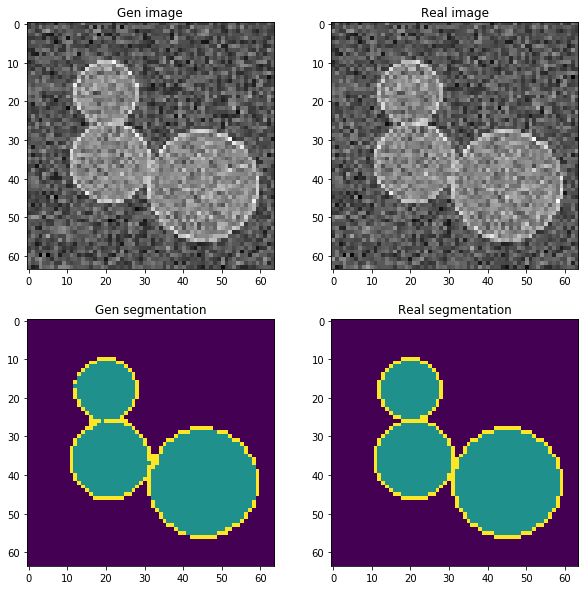

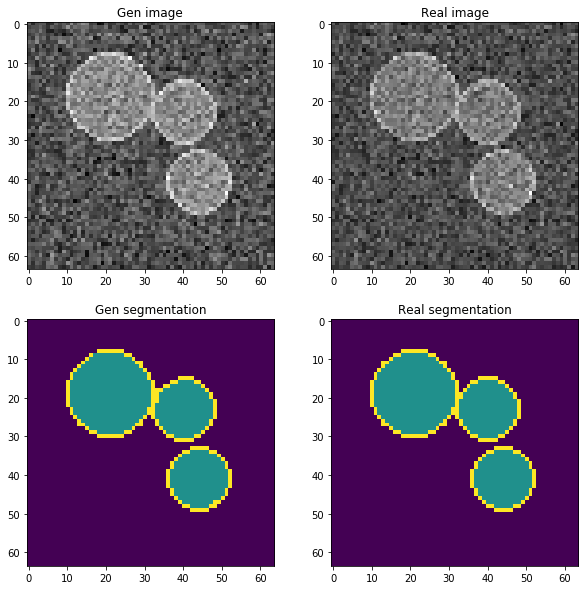

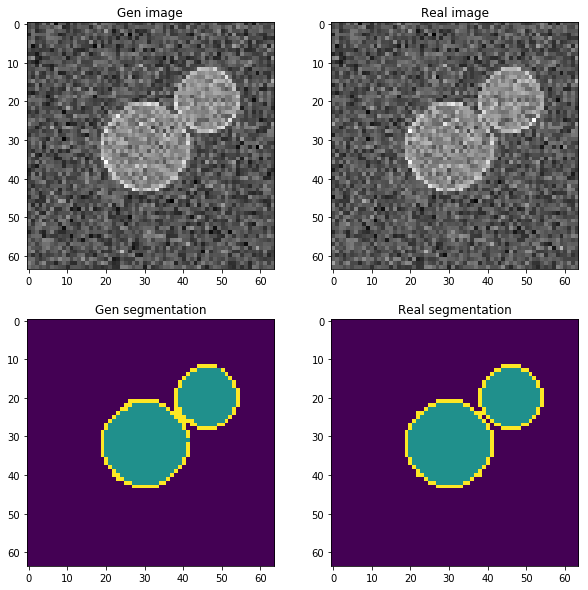

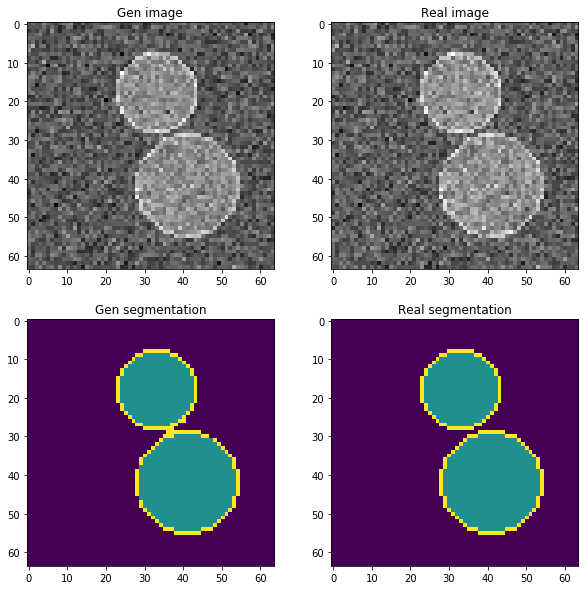

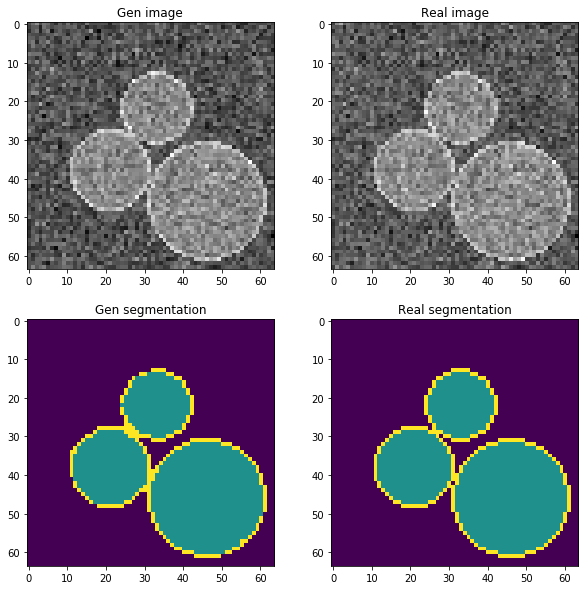

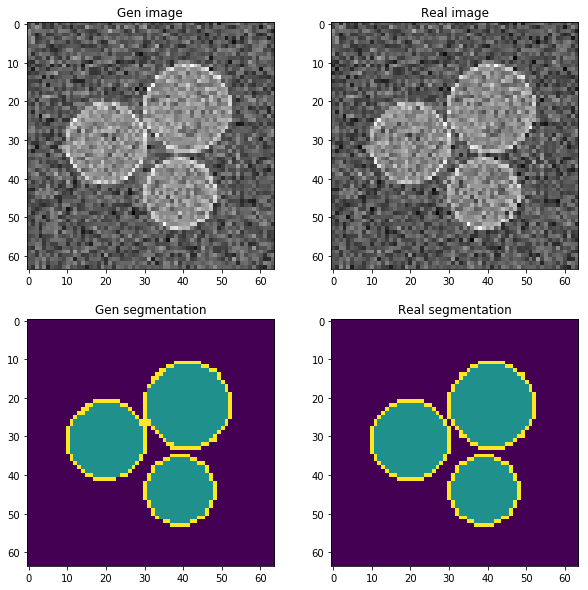

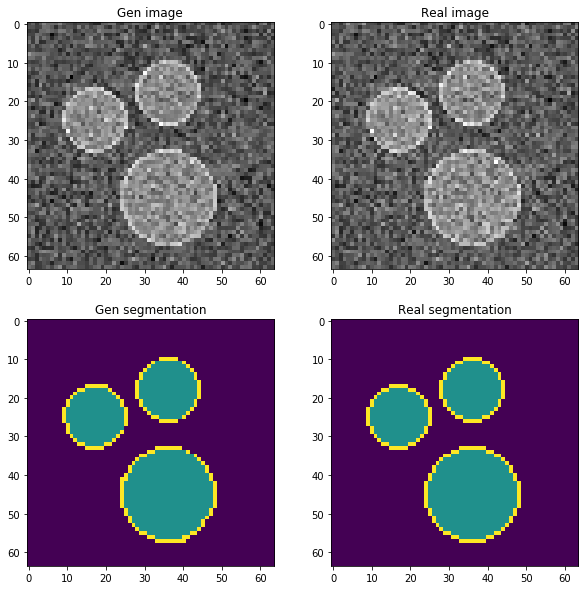

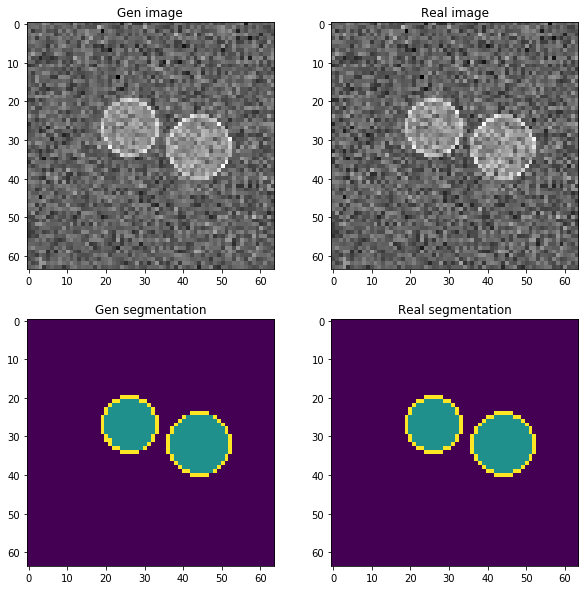

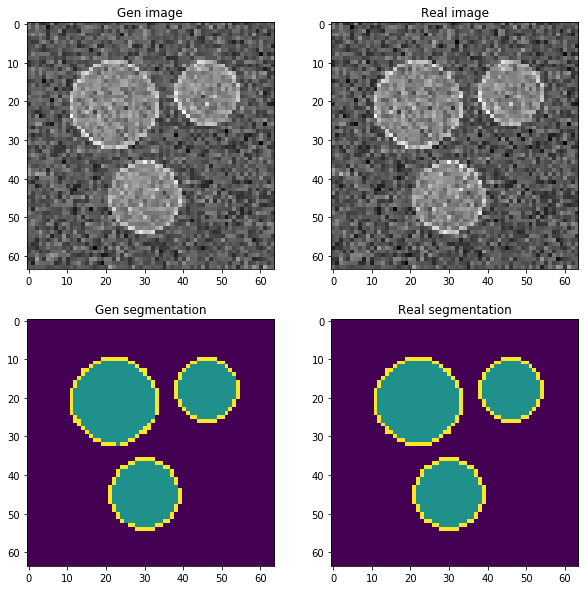

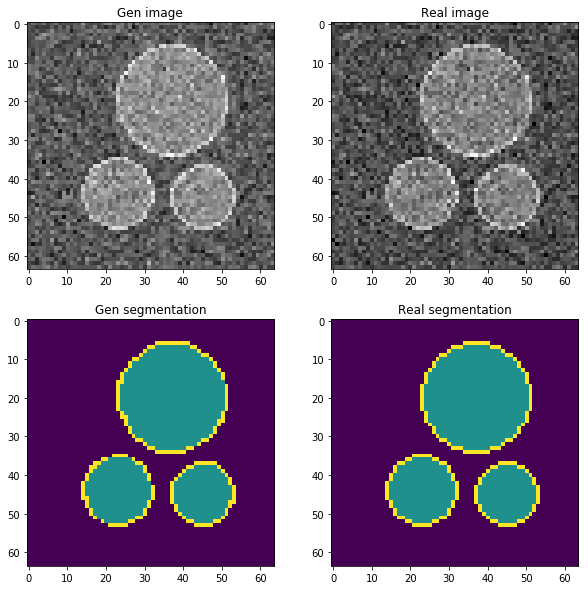

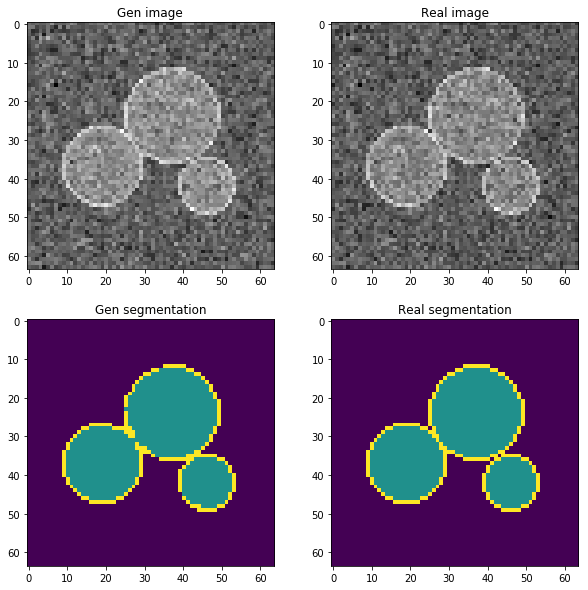

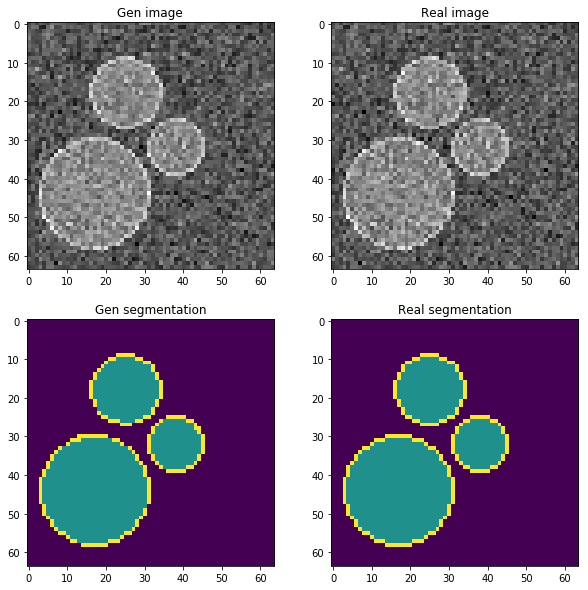

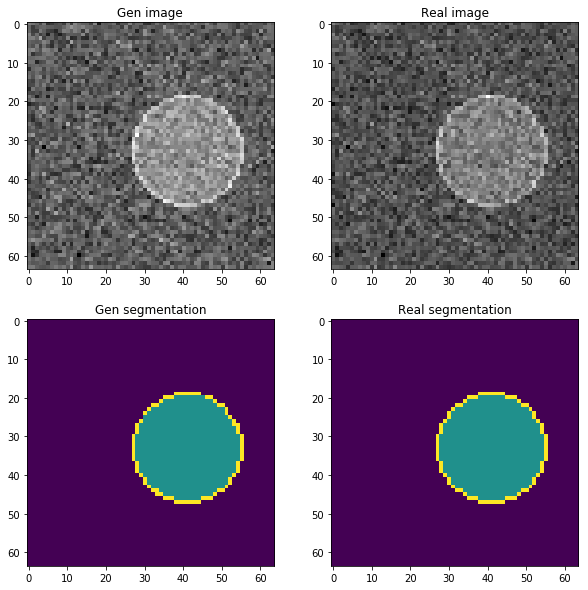

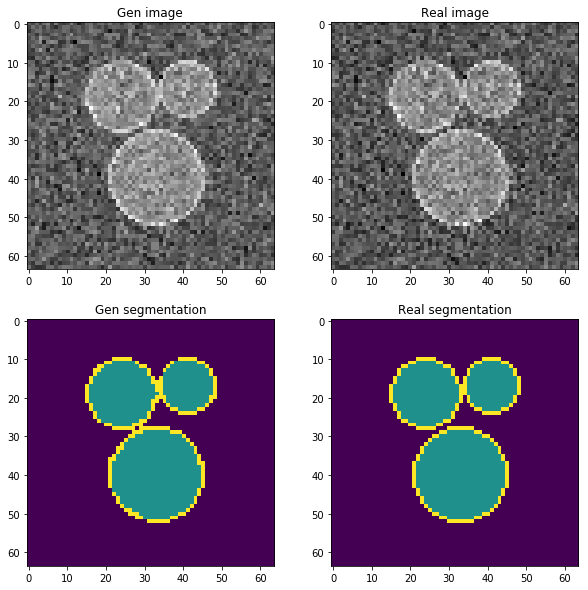

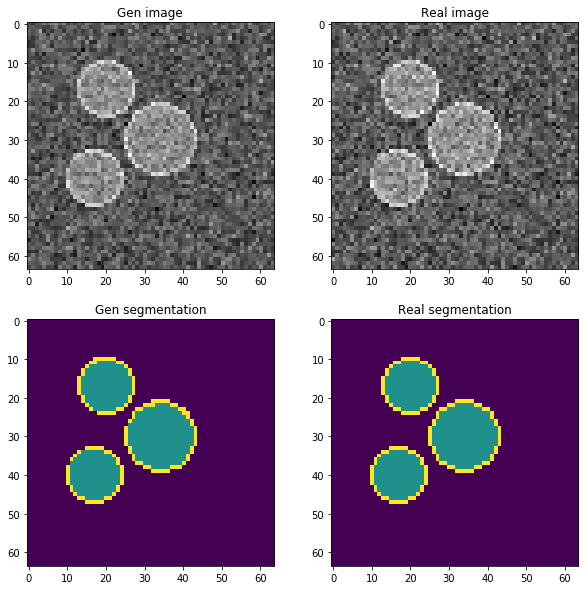

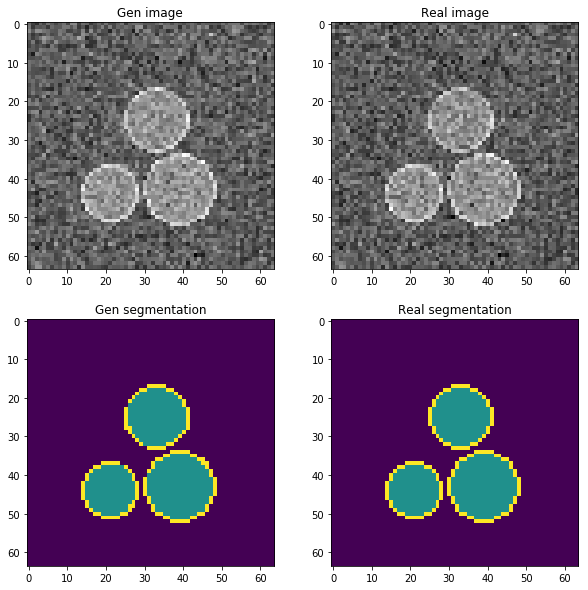

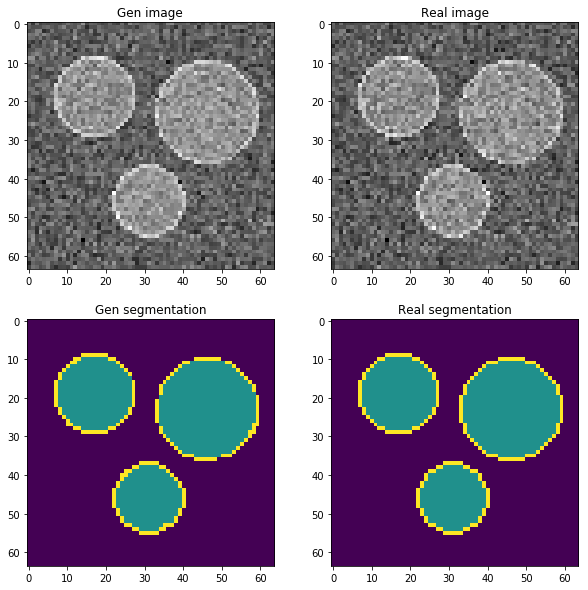

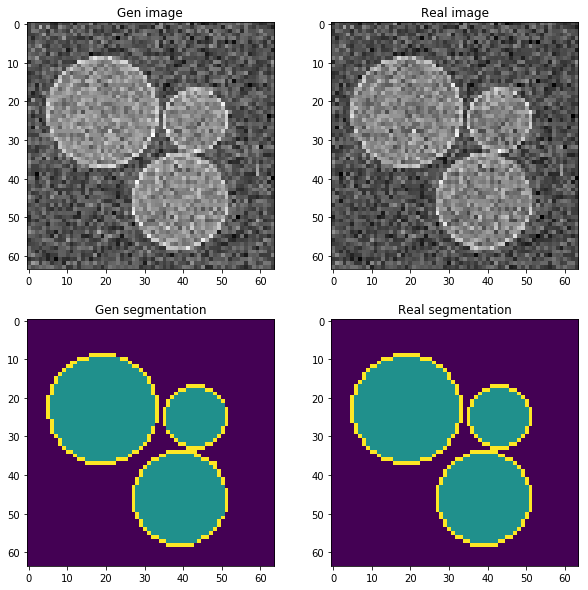

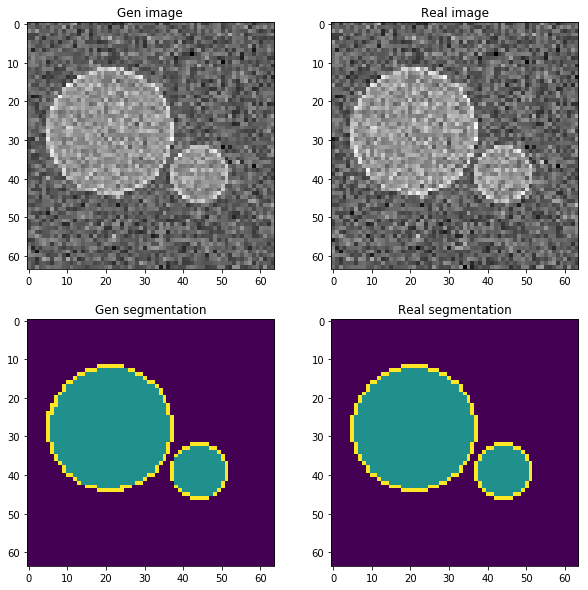

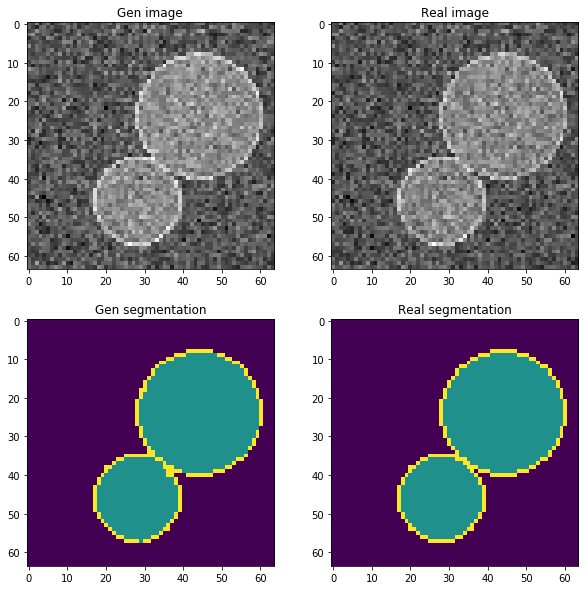

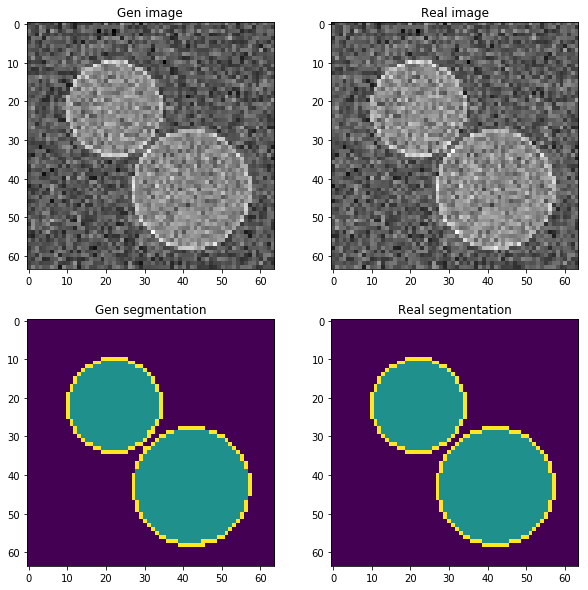

In [14]:
show_image_segm(img.data.numpy(), segm.data.numpy(), 
                train_images.data.numpy(), train_segmentation.data.numpy())

### generate test batch

In [53]:
test_batch_size = 5

In [54]:
np.random.seed(42)
test_images, test_segmentation = predata.get_train_batch(test_batch_size)

In [55]:
test_images = Variable(torch.from_numpy(test_images).float(), requires_grad=False)
test_segm = Variable(torch.from_numpy(test_segmentation), requires_grad=False)

In [56]:
torch.manual_seed(42)
z_test = Variable(torch.randn(test_batch_size, 3, 64, 64), requires_grad=True)

### Optimizing only latent variable z

In [57]:
optimizer = optim.Adam([z_test], lr=0.001)

test_loss = []
num_epochs = 300

for epoch in range(num_epochs):
    normalize_z(z_test)
    optimizer.zero_grad()   
    img, segm = net(z_test)
    loss = 1000 * img_loss(img, test_images)
    loss_epoch.append(loss.data)
    loss.backward()
    optimizer.step()
    print('epoch - {}, loss - {}'.format(epoch, loss.data.numpy()[0]))

normalize_z(z_test)

epoch - 0, loss - 12.22966480255127
epoch - 1, loss - 12.061749458312988
epoch - 2, loss - 11.896302223205566
epoch - 3, loss - 11.736021041870117
epoch - 4, loss - 11.580910682678223
epoch - 5, loss - 11.431770324707031
epoch - 6, loss - 11.286788940429688
epoch - 7, loss - 11.14680290222168
epoch - 8, loss - 11.011473655700684
epoch - 9, loss - 10.880166053771973
epoch - 10, loss - 10.75301742553711
epoch - 11, loss - 10.62867546081543
epoch - 12, loss - 10.507336616516113
epoch - 13, loss - 10.389483451843262
epoch - 14, loss - 10.275012016296387
epoch - 15, loss - 10.164484024047852
epoch - 16, loss - 10.0584135055542
epoch - 17, loss - 9.956982612609863
epoch - 18, loss - 9.857867240905762
epoch - 19, loss - 9.761510848999023
epoch - 20, loss - 9.667046546936035
epoch - 21, loss - 9.576018333435059
epoch - 22, loss - 9.486652374267578
epoch - 23, loss - 9.39840316772461
epoch - 24, loss - 9.311576843261719
epoch - 25, loss - 9.227293968200684
epoch - 26, loss - 9.145334243774414
e

epoch - 218, loss - 3.7823543548583984
epoch - 219, loss - 3.7700746059417725
epoch - 220, loss - 3.757917642593384
epoch - 221, loss - 3.745820999145508
epoch - 222, loss - 3.7337560653686523
epoch - 223, loss - 3.7218000888824463
epoch - 224, loss - 3.709880828857422
epoch - 225, loss - 3.6979939937591553
epoch - 226, loss - 3.6861042976379395
epoch - 227, loss - 3.674309015274048
epoch - 228, loss - 3.662508964538574
epoch - 229, loss - 3.650726079940796
epoch - 230, loss - 3.639047145843506
epoch - 231, loss - 3.6275017261505127
epoch - 232, loss - 3.615950107574463
epoch - 233, loss - 3.6044256687164307
epoch - 234, loss - 3.5929112434387207
epoch - 235, loss - 3.581324577331543
epoch - 236, loss - 3.5698108673095703
epoch - 237, loss - 3.558389663696289
epoch - 238, loss - 3.5470006465911865
epoch - 239, loss - 3.5356719493865967
epoch - 240, loss - 3.524484395980835
epoch - 241, loss - 3.5133185386657715
epoch - 242, loss - 3.502171516418457
epoch - 243, loss - 3.491130113601684

In [60]:
test_img, test_segm = net(z_test)

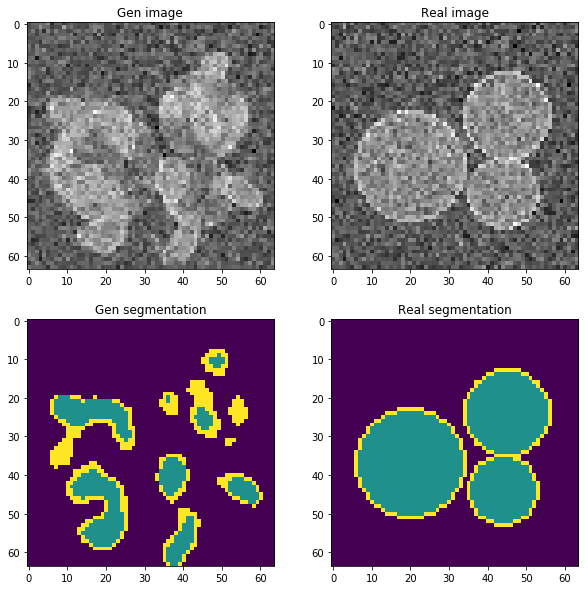

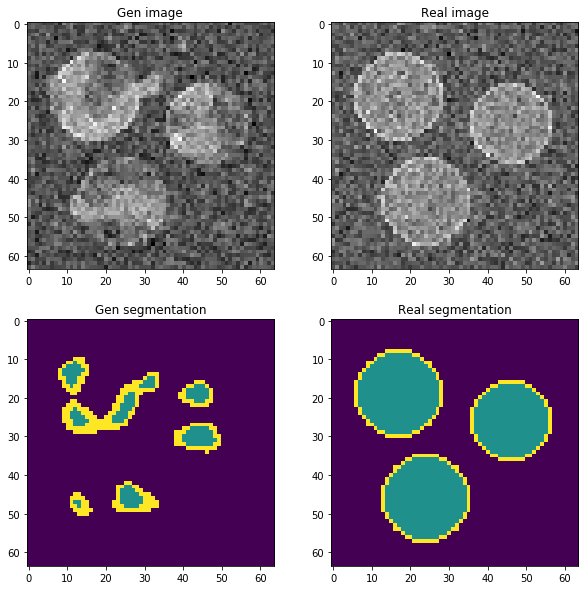

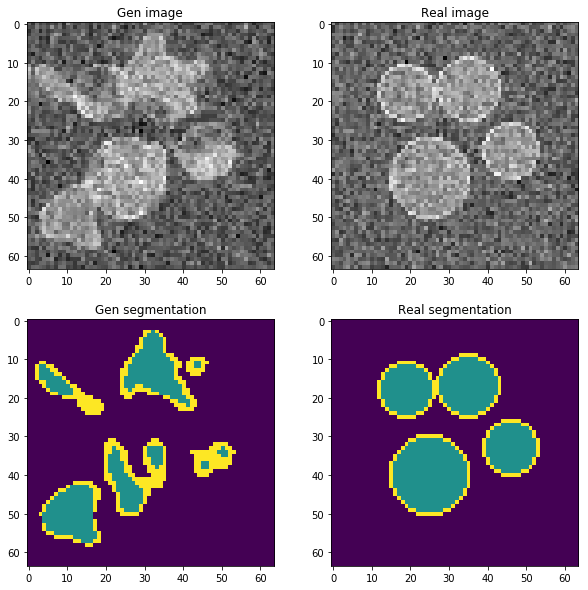

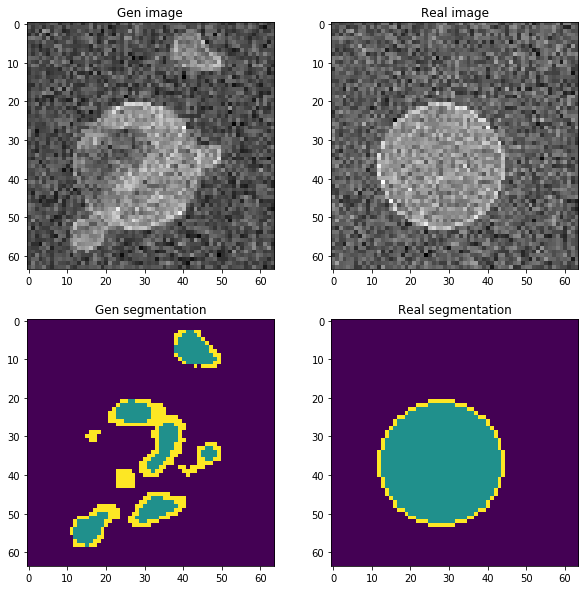

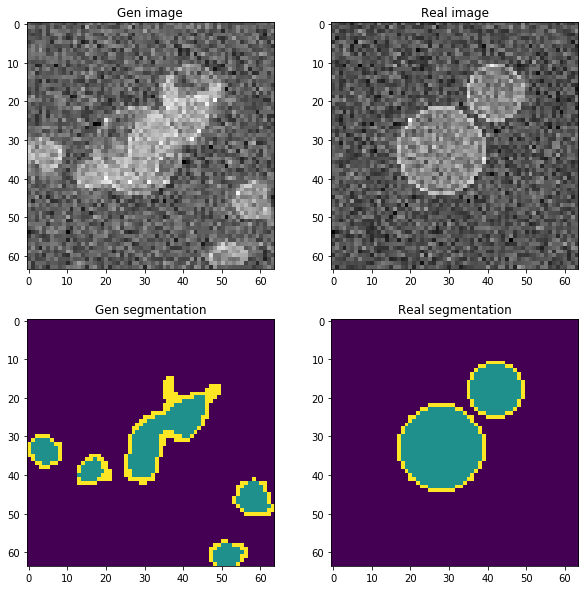

In [61]:
show_image_segm(test_img.data.numpy(), test_segm.data.numpy(), 
                test_images.data.numpy(), test_segmentation)